# Connect To Drive and Kaggle 

In [1]:
from google.colab import files

In [2]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download Dataset

In [5]:
!kaggle datasets download adityajn105/flickr8k

100% 1.04G/1.04G [00:47<00:00, 22.2MB/s]
100% 1.04G/1.04G [00:47<00:00, 23.4MB/s]


In [6]:
!unzip "/content/flickr8k.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

# Import Libraries 

In [7]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import os 
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

# Load Dataset

In [8]:
image_data_location = "/content/Images"
caption_data_location = "/content/captions.txt"

In [9]:
df = pd.read_csv(caption_data_location)
df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

# Set Device

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Preprocessing

## Split Dataset to Train and Valiation (Test)

In [11]:
train_df, test_df = train_test_split(df, test_size =.20)
train_df.reset_index(inplace = True,  drop = True )
test_df.reset_index(inplace = True,  drop = True)

In [12]:
train_df.shape

(32364, 2)

## show sample


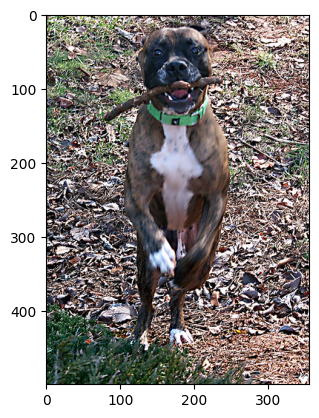

Caption - A brown and white dog is jumping up , with a stick in its mouth .
Caption - A brown dog , holding a stick .
Caption - A brown dog with green collar holding a stick in its mouth .
Caption - A dog in a green collar fetches a stick from the dead leaves .
Caption - The brown and white dog with a green collar is biting a stick .


In [13]:
def show_one_image(idx):
    idx = idx
    image_path = image_data_location + "/" + df.iloc[idx,0]
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.show()

    for i in range(idx, idx+5):
        print(f"Caption - {df.iloc[i,1]}")

def show_image(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1,2,0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
show_one_image(idx = 6000)

## Tokenize Text

In [14]:
spacy_eng = spacy.load('en_core_web_sm')

## Build Vocabulary

In [15]:
class Vocab:
    def __init__(self, freq_thresh):
        self.idx2word = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        self.word2idx  ={v:k for k,v in self.idx2word.items()}
        self.freq_threshold = freq_thresh

    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]

    def __len__(self):
        return len(self.idx2word)

    def build_vocab(self,sentences):
        frequencies = Counter()
        idx = 4
        for sentence in sentences:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                if frequencies[word] == self.freq_threshold:
                    self.word2idx[word] = idx
                    self.idx2word[idx] = word
                    idx += 1

    def numericalize(self,text):
        tokenized_text = self.tokenize(text)
        return [self.word2idx[token] if token in self.word2idx else self.word2idx["<UNK>"] for token in tokenized_text]
                

In [16]:
v = Vocab(freq_thresh=1)
v.build_vocab(["This is a new city"])
print(v.word2idx)
print(v.numericalize("This is a new city"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'new': 7, 'city': 8}
[4, 5, 6, 7, 8]


# Make Dataset and Dataloader

In [17]:
class CustomDataset(Dataset):
    def __init__(self,root_dir,train_or_test_df,transform=None, freq_threshold=5, all_data = df ):
        self.root_dir = root_dir
        self.df = train_or_test_df
        self.transform = transform
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        self.vocab = Vocab(freq_thresh =1)
        self.all_data = all_data
        self.vocab.build_vocab(self.all_data["caption"].tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
            
        caption_vec = []
        caption_vec += [self.vocab.word2idx["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.word2idx["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

In [18]:
train_dataset = CustomDataset(
        root_dir = image_data_location,
        train_or_test_df = train_df,
        transform = transforms
)

val_dataset = CustomDataset(
        root_dir = image_data_location,
        train_or_test_df = test_df,
        transform = transforms
)
len(train_dataset),  len(val_dataset)

(32364, 8091)

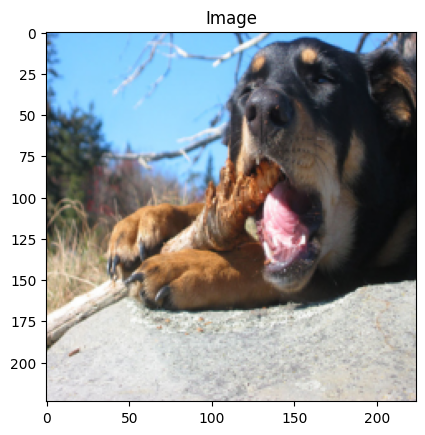

Token : tensor([   1,    4,   31, 2111,   43,    4, 5849,   18,    2])
Sentence: 
['<SOS>', 'a', 'dog', 'gnawing', 'on', 'a', 'bone', '.', '<EOS>']


In [19]:
img, caps = train_dataset[0]
show_image(img,"Image")
print("Token :",caps)
print("Sentence: ")
print([train_dataset.vocab.idx2word[token] for token in caps.tolist()])

In [20]:
def print_shape_of_tensors_in_list(list_of_tensor) :
    lens  =  []
    for t in list_of_tensor:
        lens.append(t.shape)
    print(lens)

class CapsCollate:
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
        
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [21]:
BATCH_SIZE = 16
#token to represent the padding
pad_idx = train_dataset.vocab.word2idx["<PAD>"]

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)


# Utils

In [22]:
def plot_loss(train_losses, val_losses):
    train_losses = [train_loss.detach().cpu().numpy() for train_loss in train_losses]
    val_losses = [val_loss.detach().cpu().numpy() for val_loss in  val_losses]  
    plt.plot(range(1, len(val_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def plot_image_with_caption(model,idx, val_dataset=val_dataset):
    model.eval()
    with torch.no_grad():
        img, _ = val_dataset[idx]

        features = model.encoder(img.unsqueeze(0).to(device))
        #print(f"features shape - {features.shape}")
        caps = model.decoder.generate_caption(features.unsqueeze(0),vocab=train_dataset.vocab)
        caption = ' '.join(caps)
        show_image(img,title=caption)

# Model Architecture

## Resnet 18

In [23]:
resnet18 = models.resnet18(pretrained=True)
modules = list(resnet18.children())#[:-1]
resnet18 = nn.Sequential(*modules)
resnet18

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 342MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

## Encoder Decoder (Resnet18 backbone)

In [24]:
class EncoderCNN(nn.Module):
    def __init__(self,embed_size, encoder_freeze = True):
        super(EncoderCNN,self).__init__()
        resnet = models.resnet18(pretrained=True)
        if encoder_freeze:
            for param in resnet.parameters():
                param.requires_grad_(False)
        else:
            pass
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features,embed_size)
        
    def forward(self,images):
        features = self.resnet(images)
        features = features.view(features.size(0),-1)
        features = self.embed(features)
        return features

class DecoderRNN(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,num_layers=1,drop_prob=0.3):
        super(DecoderRNN,self).__init__()
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.lstm = nn.LSTM(embed_size,hidden_size,num_layers=num_layers,batch_first=True,dropout =drop_prob )
        self.fcn = nn.Linear(hidden_size,vocab_size)
        self.drop = nn.Dropout(drop_prob)
    
    def forward(self,features, captions):
        embeds = self.embedding(captions[:,:-1])
        x = torch.cat((features.unsqueeze(1),embeds),dim=1)
        x,_ = self.lstm(x)
        x = self.fcn(x)
        return x
    
    def generate_caption(self,inputs,hidden=None,max_len=20,vocab=None):
        batch_size = inputs.size(0)      
        captions = []
        
        for i in range(max_len):
            output,hidden = self.lstm(inputs,hidden)
            output = self.fcn(output)
            output = output.view(batch_size,-1)
            predicted_word_idx = output.argmax(dim=1)
            captions.append(predicted_word_idx.item())
            if vocab.idx2word[predicted_word_idx.item()] == "<EOS>":
                break
            inputs = self.embedding(predicted_word_idx.unsqueeze(0))
        return [vocab.idx2word[idx] for idx in captions]

class EncoderDecoder(nn.Module):
    def __init__(self,embed_size,hidden_size,vocab_size,num_layers=1,drop_prob=0.3):
        super(EncoderDecoder,self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size,hidden_size,vocab_size,num_layers,drop_prob)
    
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

## Training Parameters

In [25]:
# Hyperparameters
embed_size = 200
hidden_size = 256
vocab_size = len(train_dataset.vocab)
num_layers = 1
learning_rate = 5e-5

In [26]:
model_freeze = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.word2idx["<PAD>"])
optimizer = optim.Adam(model_freeze.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


## Load Models

In [29]:
model  =  model_freeze

In [31]:
# model.load_state_dict(torch.load("/content/drive/MyDrive/NNDL-spring-2023/res18_freeze.pth",map_location=torch.device('cpu')))
model.load_state_dict(torch.load("/content/drive/MyDrive/NNDL-spring-2023/res18_unfreeze.pth",map_location=torch.device('cpu')))

<All keys matched successfully>

## Train Model - Freezed Resnet18

In [27]:
# model  =  model_freeze

In [ ]:
num_epochs =  20
train_losses = []
val_losses = []
for epoch in range(1,num_epochs+1):
    epoch_train_loss = 0 
    epoch_val_loss = 0    
    for idx, (image, captions) in enumerate(iter(train_loader)):
        image,captions = image.to(device),captions.to(device)
        optimizer.zero_grad()
        outputs = model(image, captions)
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        epoch_train_loss += loss
        loss.backward()
        optimizer.step()  
    train_losses.append((epoch_train_loss/(idx+1)))
    print("Train Loss ",train_losses[-1])
    model.eval()
    with torch.no_grad():
        for idx, (image, captions) in enumerate(iter(val_loader)):
            image,captions = image.to(device),captions.to(device)
            outputs = model(image, captions)
            loss = criterion(outputs.view(-1, vocab_size), captions.view(-1)) 
            epoch_val_loss += loss
        val_losses.append((epoch_val_loss/(idx+1)))
        print("Val Loss ", val_losses[-1])
    model.train()

torch.save(model.state_dict(), "/content/drive/MyDrive/NNDL-spring-2023/res18_freeze.pth")

Train Loss  tensor(4.6968, device='cuda:0', grad_fn=<DivBackward0>)
Val Loss  tensor(4.0251, device='cuda:0')
Train Loss  tensor(3.8294, device='cuda:0', grad_fn=<DivBackward0>)
Val Loss  tensor(3.7022, device='cuda:0')
Train Loss  tensor(3.5795, device='cuda:0', grad_fn=<DivBackward0>)
Val Loss  tensor(3.5277, device='cuda:0')
Train Loss  tensor(3.4160, device='cuda:0', grad_fn=<DivBackward0>)
Val Loss  tensor(3.4028, device='cuda:0')
Train Loss  tensor(3.2892, device='cuda:0', grad_fn=<DivBackward0>)
Val Loss  tensor(3.3068, device='cuda:0')
Train Loss  tensor(3.1906, device='cuda:0', grad_fn=<DivBackward0>)
Val Loss  tensor(3.2346, device='cuda:0')
Train Loss  tensor(3.1075, device='cuda:0', grad_fn=<DivBackward0>)
Val Loss  tensor(3.1729, device='cuda:0')
Train Loss  tensor(3.0383, device='cuda:0', grad_fn=<DivBackward0>)
Val Loss  tensor(3.1212, device='cuda:0')
Train Loss  tensor(2.9757, device='cuda:0', grad_fn=<DivBackward0>)
Val Loss  tensor(3.0728, device='cuda:0')
Train Loss

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/NNDL-spring-2023/res18_freeze_20_epoch.pth")

## Train Model Trainable Resnet18

In [ ]:
num_epochs = 10
train_losses = []
val_losses = []
for epoch in range(1,num_epochs+1):
    epoch_train_loss = 0 
    epoch_val_loss = 0    
    for idx, (image, captions) in enumerate(iter(train_loader)):
        image,captions = image.to(device),captions.to(device)
        optimizer.zero_grad()
        outputs = model(image, captions)
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        epoch_train_loss += loss
        loss.backward()
        optimizer.step()
    train_losses.append((epoch_train_loss/(idx+1)))
    print("Train Loss ",train_losses[-1])
    model.eval()
    with torch.no_grad():
        for idx, (image, captions) in enumerate(iter(val_loader)):
            image,captions = image.to(device),captions.to(device)
            outputs = model(image, captions)
            loss = criterion(outputs.view(-1, vocab_size), captions.view(-1)) 
            epoch_val_loss += loss
        val_losses.append((epoch_val_loss/(idx+1)))
        print("Val Loss ", val_losses[-1])
    model.train()

# torch.save(model.state_dict(), "/content/drive/MyDrive/NNDL-spring-2023/res18_unfreeze.pth")

Epoch: 1 loss: 3.32814
Train Loss  tensor(3.6062, device='cuda:0', grad_fn=<DivBackward0>)
Val Loss  tensor(3.4438, device='cuda:0')
Epoch: 2 loss: 3.04842
Train Loss  tensor(3.2898, device='cuda:0', grad_fn=<DivBackward0>)
Val Loss  tensor(3.2278, device='cuda:0')
Epoch: 3 loss: 2.91464
Train Loss  tensor(3.0977, device='cuda:0', grad_fn=<DivBackward0>)
Val Loss  tensor(3.0951, device='cuda:0')
Epoch: 4 loss: 3.06121
Train Loss  tensor(2.9610, device='cuda:0', grad_fn=<DivBackward0>)
Val Loss  tensor(2.9992, device='cuda:0')
Epoch: 5 loss: 2.82339
Train Loss  tensor(2.8524, device='cuda:0', grad_fn=<DivBackward0>)
Val Loss  tensor(2.9303, device='cuda:0')
Epoch: 6 loss: 3.07090
Train Loss  tensor(2.7613, device='cuda:0', grad_fn=<DivBackward0>)
Val Loss  tensor(2.8701, device='cuda:0')
Epoch: 7 loss: 2.79745
Train Loss  tensor(2.6821, device='cuda:0', grad_fn=<DivBackward0>)
Val Loss  tensor(2.8185, device='cuda:0')
Epoch: 8 loss: 2.80553
Train Loss  tensor(2.6110, device='cuda:0', gr

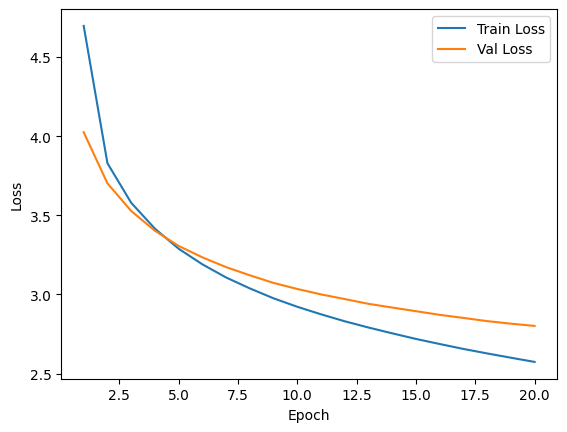

In [ ]:
plot_loss(train_losses, val_losses)

# Result

## Result Freezed ResNet18 (Part 1)

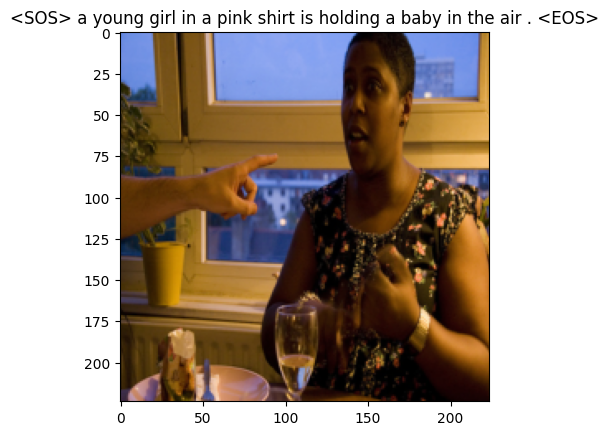

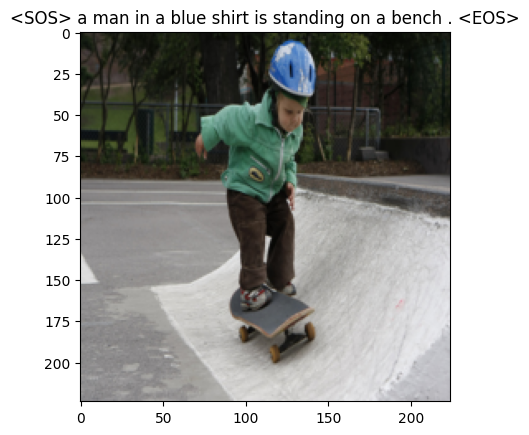

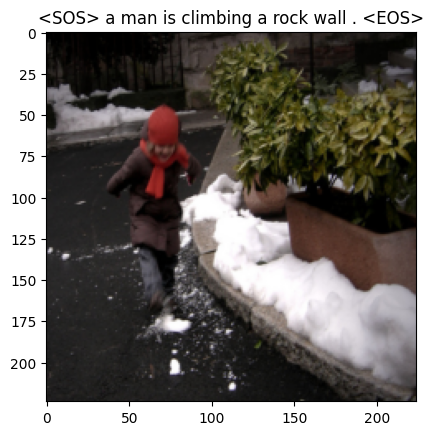

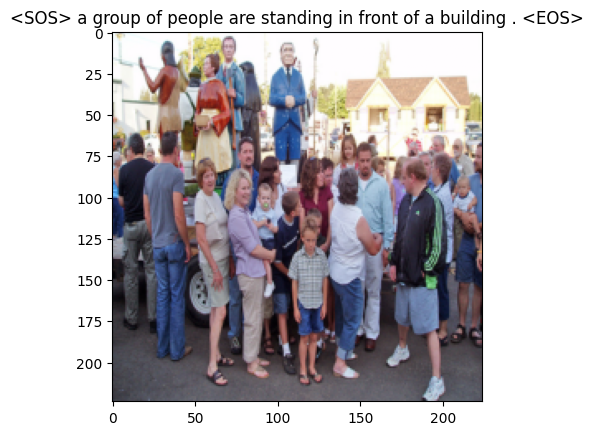

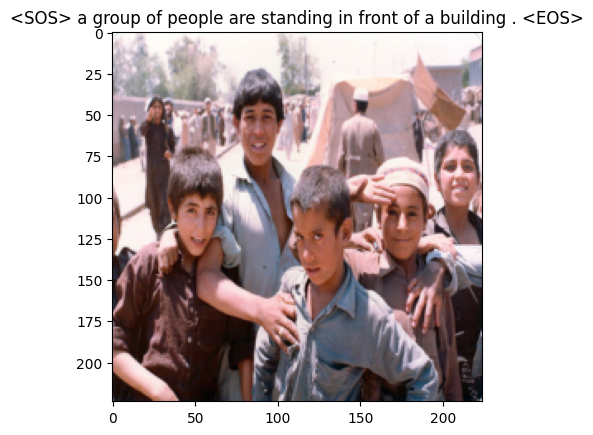

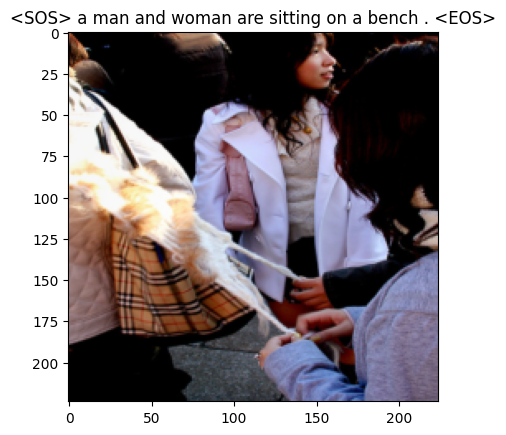

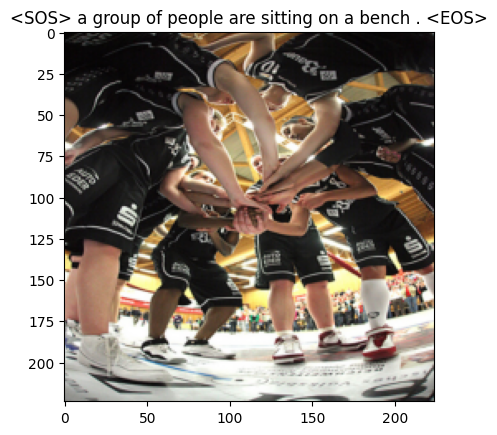

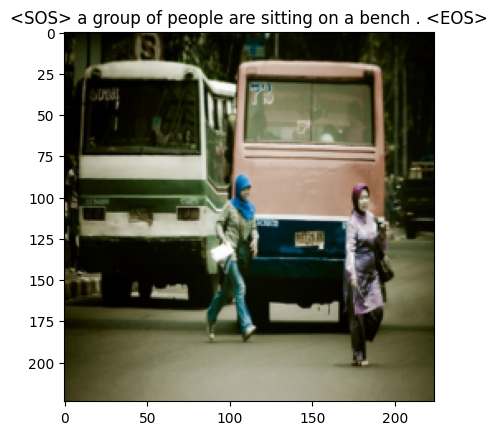

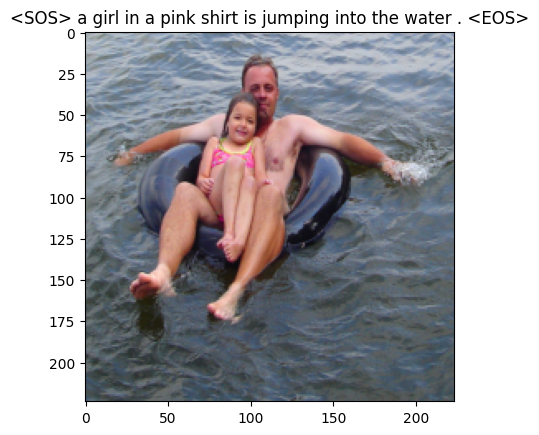

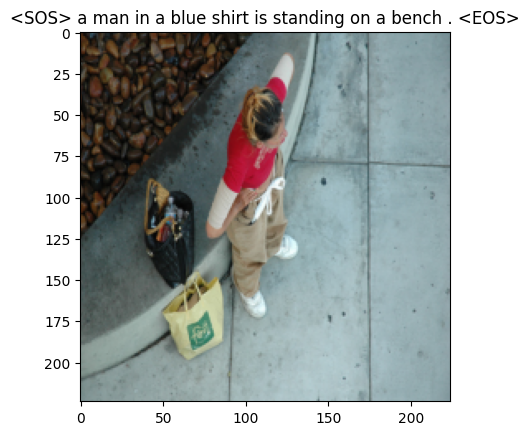

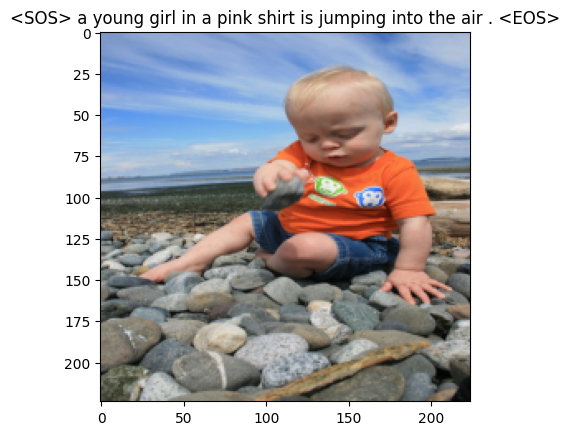

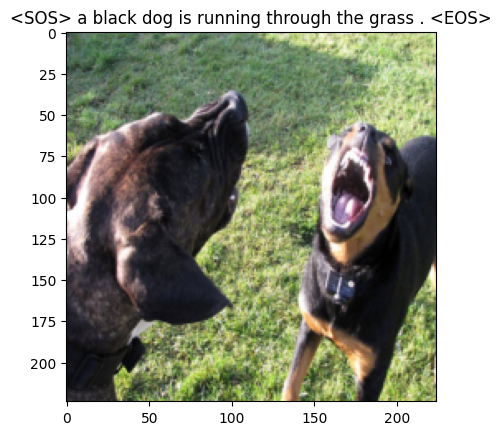

In [ ]:
for i in range(10):
    plot_image_with_caption(model,i)

## Result Trainable ResNet18 (Part 2)

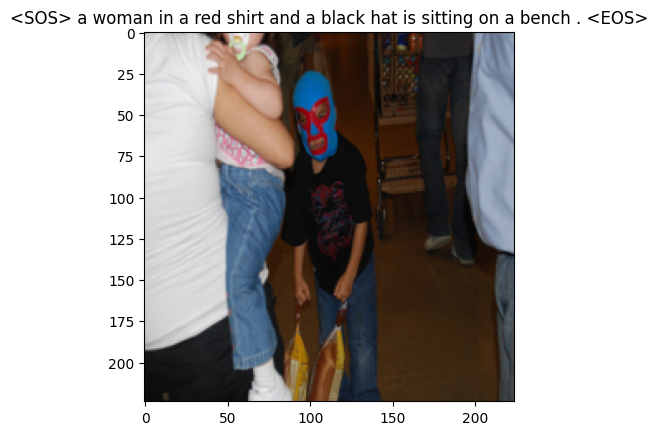

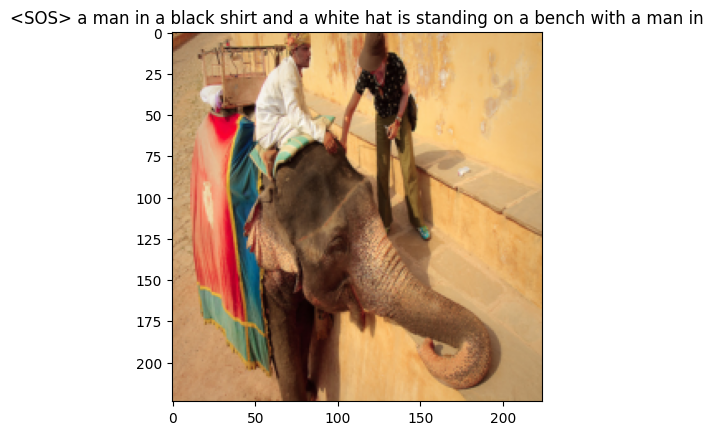

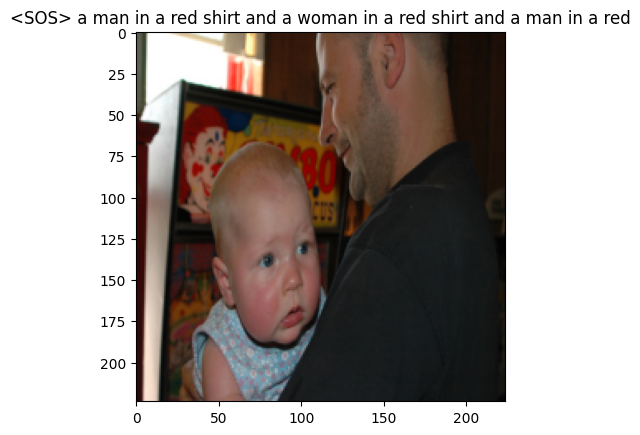

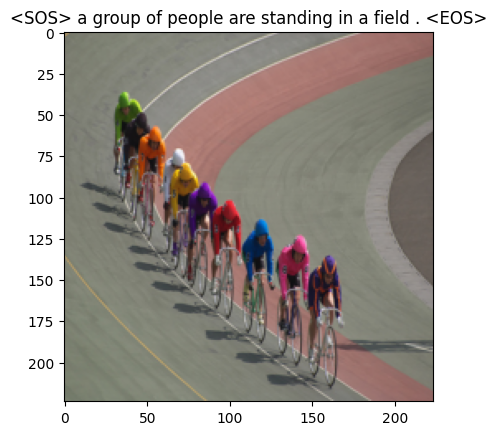

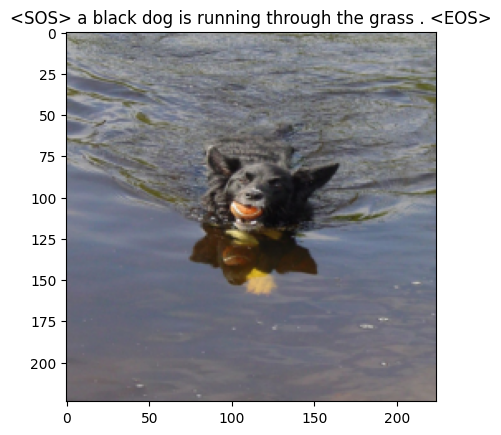

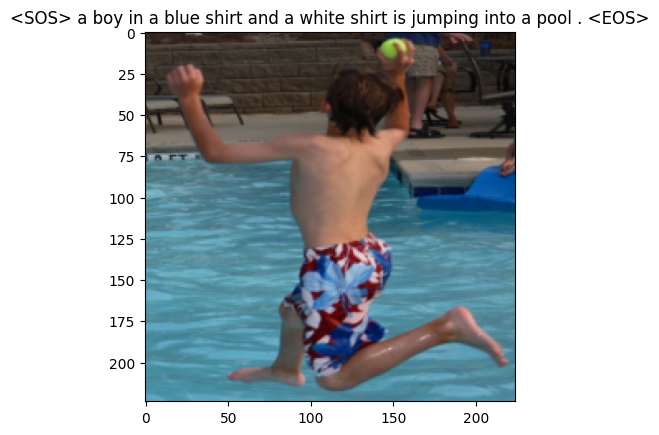

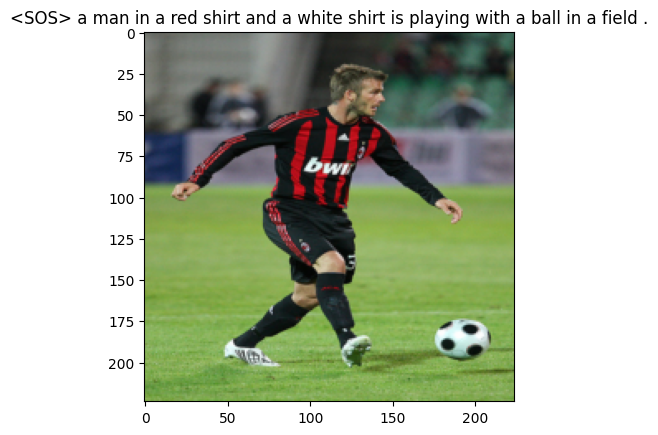

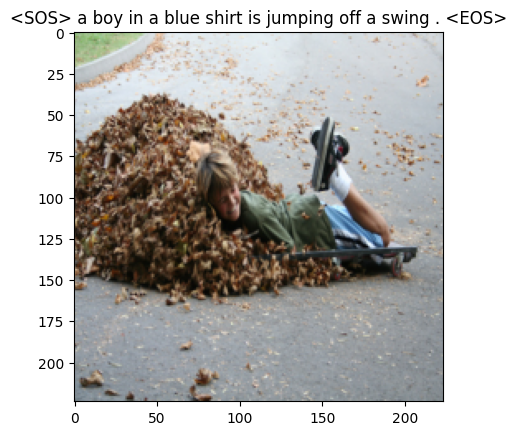

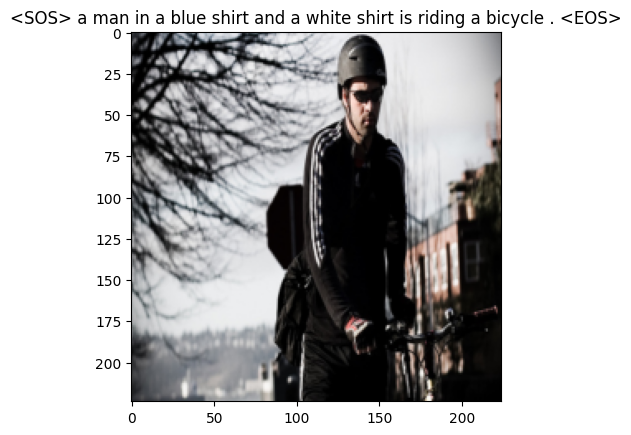

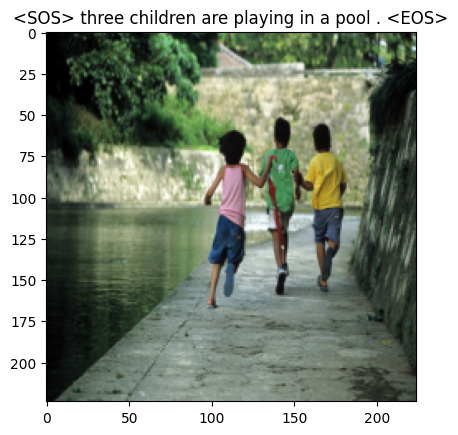

In [32]:
for i in range(10):
    plot_image_with_caption(model,i)